In [1]:
import os
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"

In [2]:
import fastf1
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
import torch
import torch.nn as nn
from IPython.display import display
from matplotlib import pyplot as plt
import pickle

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
def get_driver_data(session, driver):
    driver_data = session.laps.pick_driver(driver)
    driver_data["Driver"] = driver
    return driver_data
    

In [5]:
def adjust_laptimes(dataframe):
    dataframe["Laptime"] = dataframe["LapTime"].astype(int) * 1e-9  # Converts LapTime to seconds
    dataframe["Position(s)"] = dataframe["Position"].astype(int)  # Converts Position to integer
    new_df = dataframe.drop(columns=["LapTime", "Position"])  # Drops LapTime and Position columns
    new_df = new_df.rename(columns={"Position(s)": "Position"})  # Renames Position(s) to Position
    return new_df

def get_common(dataframe):
    new_df = dataframe[["LapNumber", "TrackStatus"]]  # Selects only LapNumber and TrackStatus
    return new_df

def get_pitstop(dataframe):
    # Replace NaT or NaN with 0 for both columns
    dataframe["PitInTime"] = dataframe["PitInTime"].fillna(0)
    dataframe["PitOutTime"] = dataframe["PitOutTime"].fillna(0)
    
    # Convert Timedelta to seconds using total_seconds()
    dataframe["PitInTime"] = dataframe["PitInTime"].apply(lambda x: float(x.total_seconds()) if isinstance(x, pd.Timedelta) else x)
    dataframe["PitOutTime"] = dataframe["PitOutTime"].apply(lambda x: float(x.total_seconds()) if isinstance(x, pd.Timedelta) else x)
    
    # Create the PitstopTime column as the difference between PitOutTime and PitInTime
    
    return dataframe
    

In [6]:
def remove_extras(dataframe):
    new_df = dataframe[["Driver", "Laptime", "PitstopTime", "Position", "Compound", "Position", "Source"]]  # Drops unnecessary columns
    return new_df


In [7]:
def drop_unecessary_telem(dataframe):
    dropped_dataframe = dataframe.drop(columns=["DriverAhead", 'SessionTime', 'Date', 'Time'])
    guess_free_dataframe = dropped_dataframe[dropped_dataframe['Source'] != 'interpolation']
    return guess_free_dataframe

In [8]:
from concurrent.futures import ThreadPoolExecutor

In [9]:
drivers = ['VER', 'PER', 'LEC', 'SAI', 'HAM', 'NOR', 'ALO', 'RUS', 'OCO']
years = [2022, 2023, 2024]

retirements = [('RUS',2022), ('OCO', 2022), ('OCO', 2023), ('RUS', 2024)]

sessions = {}

for year in years:
    print(f"Loading {year} Silverstone Race...")
    session = fastf1.get_session(year, "Silverstone", "R")
    session.load(telemetry=True)
    sessions[year] = session




# def process_driver_telemetry(driver, year):

#     telemetry_frames = []

#     session = fastf1.get_session(year, 'Silverstone', 'R')
#     session.load(telemetry=True)
        
#     for driver in drivers:
#         driver_data = session.laps.pick_driver(driver)
#         driver_data["Driver"] = driver

#         for _, lap in driver_data.iterlaps():
#             telemetry = lap.get_telemetry()

#             # Add lap-level info to every telemetry sample in this lap
#             telemetry['LapNumber'] = lap['LapNumber']
#             telemetry['LapTime'] = lap['LapTime']
#             telemetry['Compound'] = lap['Compound']
#             telemetry['TyreLife'] = lap['TyreLife']
#             telemetry['Driver'] = driver
#             telemetry['Year'] = year

#             telemetry_frames.append(telemetry)

#     return pd.concat(telemetry_frames, ignore_index=True)

# tasks = [(d, y) for y in years for d in drivers]

# with ThreadPoolExecutor(max_workers=8) as executor:
#     results = list(executor.map(lambda args: process_driver_telemetry(*args), tasks))


req         WARNING 	DEFAULT CACHE ENABLED! (24.0 KB) C:\Users\smmey\AppData\Local\Temp\fastf1


Loading 2022 Silverstone Race...


core           INFO 	Loading data for British Grand Prix - Race [v3.7.0]
req            INFO 	No cached data found for session_info. Loading data...
_api           INFO 	Fetching session info data...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for driver_info. Loading data...
_api           INFO 	Fetching driver list...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for session_status_data. Loading data...
_api           INFO 	Fetching session status data...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for lap_count. Loading data...
_api           INFO 	Fetching lap count data...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for track_status_data. Loading data...
_api           INFO 	Fetching track status data...
req            INFO 	Data has been written to cache!
req            INFO 	No ca

Loading 2023 Silverstone Race...


req            INFO 	No cached data found for session_info. Loading data...
_api           INFO 	Fetching session info data...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for driver_info. Loading data...
_api           INFO 	Fetching driver list...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for session_status_data. Loading data...
_api           INFO 	Fetching session status data...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for lap_count. Loading data...
_api           INFO 	Fetching lap count data...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for track_status_data. Loading data...
_api           INFO 	Fetching track status data...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for _extended_timing_data. Loading data...
_api          

Loading 2024 Silverstone Race...


req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for driver_info. Loading data...
_api           INFO 	Fetching driver list...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for session_status_data. Loading data...
_api           INFO 	Fetching session status data...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for lap_count. Loading data...
_api           INFO 	Fetching lap count data...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for track_status_data. Loading data...
_api           INFO 	Fetching track status data...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for _extended_timing_data. Loading data...
_api           INFO 	Fetching timing data...
_api           INFO 	Parsing timing data...
req            INFO 	Data has been written to cache!

In [10]:
telemetry_frames = []

for year, session in sessions.items():
    for driver in drivers:

        if (driver, year) in retirements:
            continue
        driver_data = session.laps.pick_driver(driver)
        driver_data["Driver"] = driver

        for _, lap in driver_data.iterlaps():
            telemetry = lap.get_telemetry()
            telemetry["LapNumber"] = lap["LapNumber"]
            telemetry["LapTime"] = lap["LapTime"]
            telemetry["Compound"] = lap["Compound"]
            telemetry["TyreLife"] = lap["TyreLife"]
            telemetry["Driver"] = driver
            telemetry["Year"] = year

            telemetry_frames.append(telemetry)

driver_telemetry = pd.concat(telemetry_frames, ignore_index=True)

c:\Users\smmey\Documents\F1_Project\.venv\Lib\site-packages\fastf1\core.py:3081: FutureWarning: pick_driver is deprecated and will be removed in a future release. Use pick_drivers instead.
  warnings.warn(("pick_driver is deprecated and will be removed"
C:\Users\smmey\AppData\Local\Temp\ipykernel_28928\1085407614.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  driver_data["Driver"] = driver
c:\Users\smmey\Documents\F1_Project\.venv\Lib\site-packages\fastf1\core.py:3081: FutureWarning: pick_driver is deprecated and will be removed in a future release. Use pick_drivers instead.
  warnings.warn(("pick_driver is deprecated and will be removed"
C:\Users\smmey\AppData\Local\Temp\ipykernel_28928\1085407614.py:9: SettingWithCopyWarning: 
A value is t

In [11]:
driver_telemetry_raw = pd.DataFrame(drop_unecessary_telem(driver_telemetry))

In [12]:
driver_telemetry = driver_telemetry_raw.copy()

In [13]:
test = driver_telemetry.groupby(['Driver', 'Year'])['LapNumber'].nunique()
test

Driver  Year
ALO     2022    52
        2023    52
        2024    52
HAM     2022    52
        2023    52
        2024    52
LEC     2022    52
        2023    52
        2024    51
NOR     2022    52
        2023    52
        2024    52
OCO     2024    50
PER     2022    52
        2023    52
        2024    50
RUS     2023    52
SAI     2022    52
        2023    52
        2024    52
VER     2022    52
        2023    52
        2024    52
Name: LapNumber, dtype: int64

In [14]:
def adjust_laptimes(dataframe: pd.DataFrame):
    dataframe["Laptime"] = pd.to_timedelta(dataframe["LapTime"]).dt.total_seconds()
    dataframe.drop(columns=["LapTime"], inplace=True)  # Converts LapTime to seconds # Drops LapTime and Position columns
    return dataframe

In [15]:
test_laptimes = pd.DataFrame({
    'LapTime': [pd.Timedelta('1 days 2 hours 30 minutes'), 
                 pd.Timedelta('0 days 1 hour 15 minutes 45 seconds')]
})

adjust_laptimes(test_laptimes)

,Laptime
0,95400.0
1,4545.0


In [16]:
driver_telemetry = adjust_laptimes(driver_telemetry)

test_render = driver_telemetry.copy()

In [17]:
test_render["Driver"].unique()

array(['VER', 'PER', 'LEC', 'SAI', 'HAM', 'NOR', 'ALO', 'RUS', 'OCO'],
      dtype=object)

### Min Max and Normalize

In [18]:
from sklearn.preprocessing import MinMaxScaler

In [19]:
scaler = MinMaxScaler()

normalize_columns = ['RPM', 'DistanceToDriverAhead', 'Speed', 'Distance', 'X', 'Y', 'Z', 'RPM', 'Throttle', 'RelativeDistance']


driver_telemetry[normalize_columns] = scaler.fit_transform(pd.DataFrame(driver_telemetry[normalize_columns]))



In [20]:
driver_telemetry['Brake'] = driver_telemetry['Brake'].astype(int)

In [21]:
lap_times_label = driver_telemetry.groupby(['Year', 'Driver', 'LapNumber'], as_index=False)[['Laptime']].max()

laptime_scaler = MinMaxScaler()

lap_times_label['Laptime'] = (
    lap_times_label
    .groupby(['Driver', 'Year'])['Laptime']
    .transform(lambda x: laptime_scaler.fit_transform(x.values.reshape(-1, 1)).flatten())
)

In [22]:
tyre_encr = LabelEncoder()

driver_telemetry["Compound"] = tyre_encr.fit_transform(driver_telemetry["Compound"])

In [23]:
driver_encr = LabelEncoder()

driver_telemetry["Driver"] = driver_encr.fit_transform(driver_telemetry["Driver"])
lap_times_label["Driver"] = driver_encr.fit_transform(lap_times_label["Driver"])

normalized_test = driver_telemetry.copy()

In [24]:
driver_encr.classes_

array(['ALO', 'HAM', 'LEC', 'NOR', 'OCO', 'PER', 'RUS', 'SAI', 'VER'],
      dtype=object)

In [25]:
normalized_test["Driver"].unique()

array([8, 5, 2, 7, 1, 3, 0, 6, 4])

In [26]:
year_encr = LabelEncoder()

driver_telemetry["Year"] = year_encr.fit_transform(driver_telemetry["Year"])
lap_times_label["Year"] = year_encr.fit_transform(lap_times_label["Year"])

In [27]:
driver_telemetry.shape

(894142, 20)

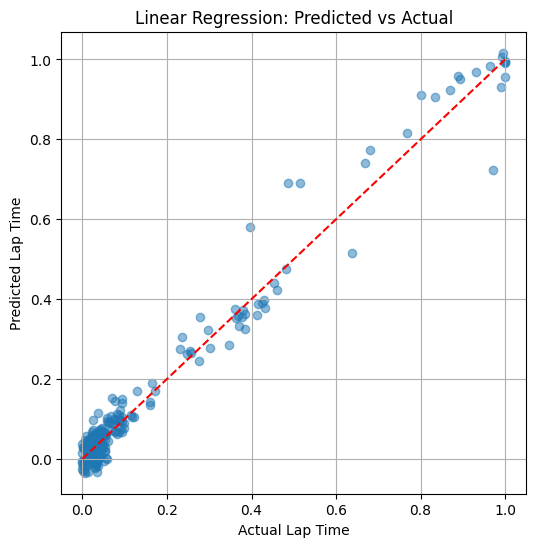

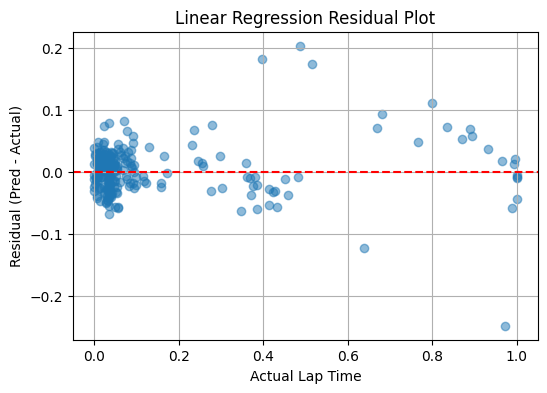

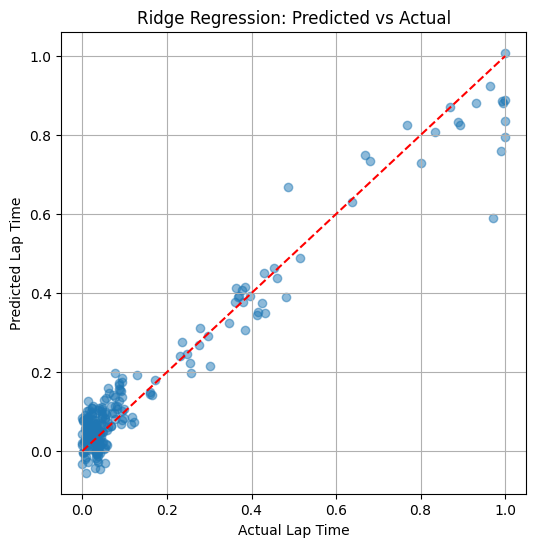

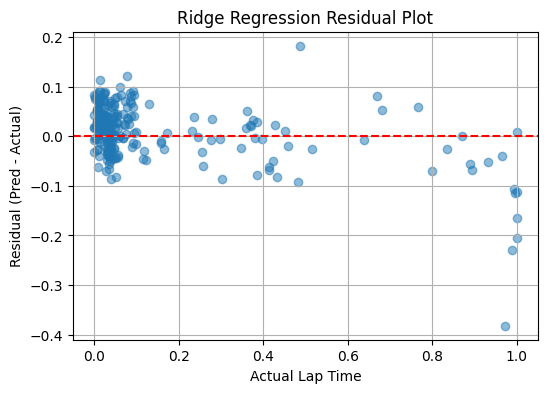

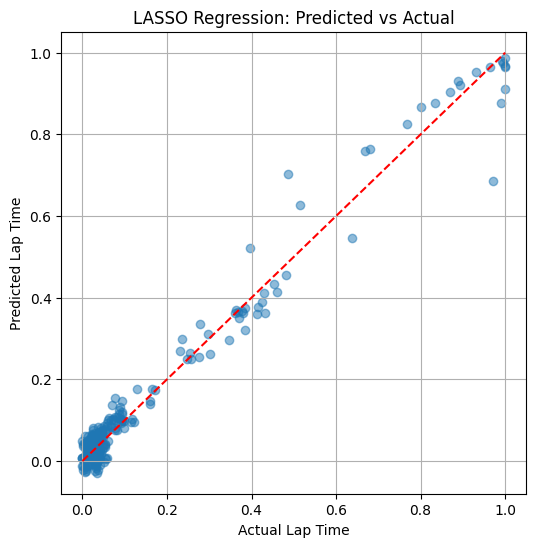

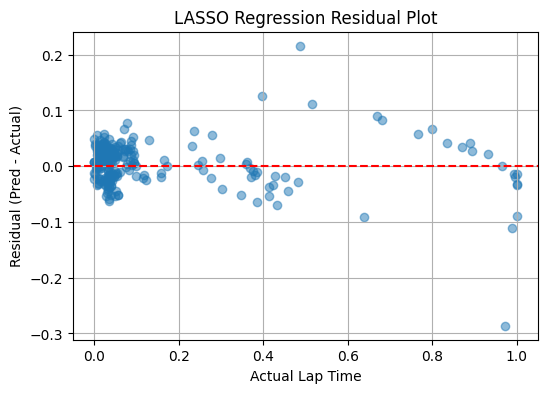


==== Linear Regression ====
MAE: 0.0292020296077448
R²: 0.9714797819962178

==== Linear Regression ====
MAE: 0.0292020296077448
R²: 0.9714797819962178

==== Ridge Regression ====
MAE: 0.042512385030119906
R²: 0.9441688139553192

==== Ridge Regression ====
MAE: 0.042512385030119906
R²: 0.9441688139553192

==== LASSO Regression ====
MAE: 0.029854738893072323
R²: 0.9722230713260874

==== LASSO Regression ====
MAE: 0.029854738893072323
R²: 0.9722230713260874


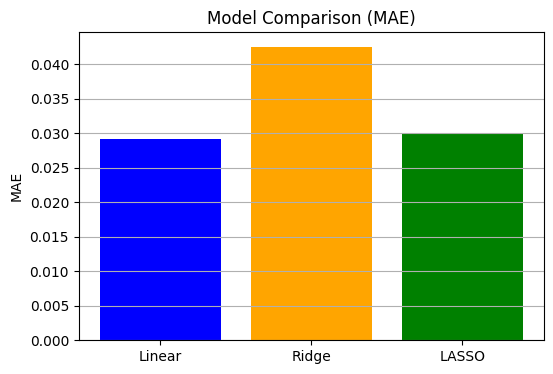

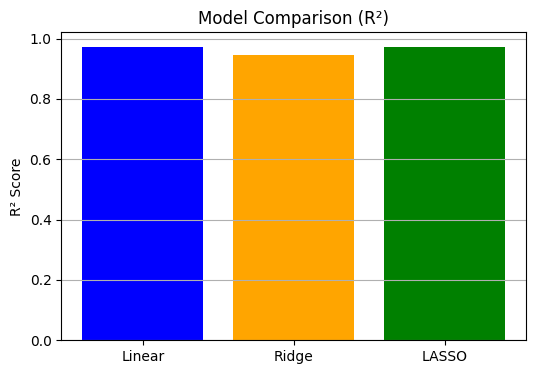

In [33]:
lap_features = driver_telemetry.groupby(
    ['Year', 'Driver', 'LapNumber'],
    as_index=False
).agg({
    'Speed': 'mean',
    'Throttle': 'mean',
    'Brake': 'mean',
    'RPM': 'mean',
    'TyreLife': 'max',
    'Compound': 'max',   
    'Driver': 'max',
    'Year': 'max'
})

lap_features['LapNumber'] = lap_features['LapNumber'].astype(float)

regression_df = lap_features.merge(
    lap_times_label[['Year','Driver','LapNumber','Laptime']],
    on=['Year','Driver','LapNumber'],
    how='inner'
)

regression_df = regression_df.dropna(subset=["Laptime"])

from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score

feature_cols = [
    'Speed','Throttle','Brake','RPM',
    'TyreLife','Compound','Driver','Year','LapNumber'
]

X = regression_df[feature_cols]
y = regression_df["Laptime"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

models = {
    "Linear": LinearRegression(),
    "Ridge": Ridge(alpha=1.0),
    "LASSO": Lasso(alpha=0.0005)
}

for name, model in models.items():
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    plt.figure(figsize=(6,6))
    plt.scatter(y_test, preds, alpha=0.5)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')

    plt.xlabel("Actual Lap Time")
    plt.ylabel("Predicted Lap Time")
    plt.title(f"{name} Regression: Predicted vs Actual")
    plt.grid(True)
    plt.show()

    residuals = preds - y_test

    plt.figure(figsize=(6,4))
    plt.scatter(y_test, residuals, alpha=0.5)
    plt.axhline(0, color='red', linestyle='--')

    plt.xlabel("Actual Lap Time")
    plt.ylabel("Residual (Pred - Actual)")
    plt.title(f"{name} Regression Residual Plot")
    plt.grid(True)
    plt.show()


mae_scores = {}
r2_scores = {}

for name, model in models.items():
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    
    mae = mean_absolute_error(y_test, preds)
    r2 = r2_score(y_test, preds)

    mae_scores[name] = mae
    r2_scores[name] = r2

    print(f"\n==== {name} Regression ====")
    print("MAE:", mae)
    print("R²:", r2)
    

    print(f"\n==== {name} Regression ====")
    print("MAE:", mean_absolute_error(y_test, preds))
    print("R²:", r2_score(y_test, preds))

plt.figure(figsize=(6,4))
plt.bar(mae_scores.keys(), mae_scores.values(), color=['blue','orange','green'])
plt.ylabel("MAE")
plt.title("Model Comparison (MAE)")
plt.grid(axis='y')
plt.show()

plt.figure(figsize=(6,4))
plt.bar(r2_scores.keys(), r2_scores.values(), color=['blue','orange','green'])
plt.ylabel("R² Score")
plt.title("Model Comparison (R²)")
plt.grid(axis='y')
plt.show()


In [ ]:
pad_max = (0, 0)
avg = 0
count = 0
lengths = []
ver_length = []

for (year, driver), driver_df in driver_telemetry.groupby(['Year', 'Driver']):
    for lap_num in sorted(driver_df['LapNumber'].unique()):
        curr = driver_df[driver_df['LapNumber'] == lap_num].shape[0]
        avg += curr
        count += 1
        lengths.append(curr)
        if year == 2 and driver == 8:
            ver_length.append(curr)
        
        if curr > pad_max[1]:
            pad_max = ((year, driver, lap_num), curr)

print("Most telemetry points in 1 lap:", pad_max)
print("Average Telemetry Points per Lap:", avg // count)
print("Total laps counted:", len(lengths))

In [ ]:
driver_telemetry.shape
driver_telemetry.columns

In [ ]:
laps_with_times = driver_telemetry.loc[
    driver_telemetry['Laptime'].notnull(),
    ['Year', 'Driver', 'LapNumber']
].drop_duplicates()

print(len(laps_with_times))
print(laps_with_times.head())

In [ ]:
driver_telemetry = driver_telemetry.drop(columns=['Laptime'])

In [ ]:
padded_data = []

for (driver, year), driver_df in driver_telemetry.groupby(["Driver", "Year"]):
    for lap_num in driver_df["LapNumber"].unique():
        lap_data = driver_df[driver_df["LapNumber"] == lap_num]
        telem_points = lap_data.shape[0]

        if telem_points < pad_max[1]:
            padding = pd.DataFrame(
                np.full((pad_max[1] - telem_points, lap_data.shape[1]), -999),
                columns=lap_data.columns
            )
            padding["LapNumber"] = lap_num
            padding["Driver"] = driver
            padding["Year"] = year

            lap_data = pd.concat([lap_data, padding], ignore_index=True)

        padded_data.append(lap_data)

driver_telemetry = pd.concat(padded_data, ignore_index=True)


In [ ]:
driver_telemetry = driver_telemetry.drop(columns=['Source', 'Status'])

In [ ]:
driver_telemetry.columns

In [ ]:
# --- Ensure consistent data types across both DataFrames ---
driver_telemetry["Driver"] = driver_telemetry["Driver"].astype(str)
lap_times_label["Driver"] = lap_times_label["Driver"].astype(str)
driver_telemetry["LapNumber"] = driver_telemetry["LapNumber"].astype(int)
lap_times_label["LapNumber"] = lap_times_label["LapNumber"].astype(int)
driver_telemetry["Year"] = driver_telemetry["Year"].astype(int)
lap_times_label["Year"] = lap_times_label["Year"].astype(int)

# --- Get unique lap identifiers including Year ---
telemetry_keys = set(driver_telemetry.groupby(["Year", "Driver", "LapNumber"]).groups.keys())
label_keys = set(zip(lap_times_label["Year"], lap_times_label["Driver"], lap_times_label["LapNumber"]))

In [ ]:
# merge to ensure exact lap matching
merged = driver_telemetry.merge(
    lap_times_label,
    on=["Year", "Driver", "LapNumber"],
    how="inner"
)

# verify perfect alignment
print("Unique laps after merge:", merged.groupby(["Year", "Driver", "LapNumber"]).ngroups)


In [ ]:
merged["Driver"] = merged['Driver'].astype(int)

In [ ]:
X, y = [], []

clean_merged = merged.groupby(["Year", "Driver", "LapNumber"])

for (year, driver, lap_num), lap_df in clean_merged:
    lap_vals = lap_df.drop(columns=["Laptime"]).values
    X.append(lap_vals)


In [ ]:
driver_telemetry.columns

In [ ]:
X = np.stack(X).astype(np.float32)


telemetry_idx = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
lap_idx = [12, 14]
tyre_idx = [13]
driver_idx = [15]
year_idx = [16]
telemetry = torch.tensor(X[:, :, telemetry_idx], dtype=torch.float32)

telemetry = torch.nan_to_num(telemetry, nan=0.0, posinf=0.0, neginf=0.0)

tyre_context = torch.tensor(X[:, 0, tyre_idx], dtype=torch.long).squeeze(-1)
lap_context = torch.tensor(X[:, 0, lap_idx], dtype=torch.float32)
driver_context= torch.tensor(X[:, 0, driver_idx], dtype=torch.long).squeeze(-1)
year_context  = torch.tensor(X[:, 0, year_idx], dtype=torch.long).squeeze(-1)

lap_times_label["Laptime"] = lap_times_label["Laptime"].replace([np.inf, -np.inf], np.nan)
lap_times_label["Laptime"] = lap_times_label["Laptime"].fillna(0.0)

y = torch.tensor(lap_times_label["Laptime"].values, dtype=torch.float32)

lengths = torch.tensor(lengths, dtype=torch.long)

In [ ]:
class SilverstoneModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.driver_embedding = nn.Embedding(9, 10)
        self.year_embedding = nn.Embedding(3, 2)
        self.tyre_embeding = nn.Embedding(4, 3)
        self.lap_dense = nn.Linear(in_features=2, out_features=8)
        self.lstm1 = nn.LSTM(12, 64, batch_first=True)
        self.lstm2 = nn.LSTM(64, 128, batch_first=True)
        self.sequential = nn.Sequential(
            nn.Linear(in_features=151, out_features=24),
            nn.Linear(in_features=24, out_features=1)
        )

    def forward(self, telemetry, tyre_context, lap_context, year_context, driver_context, lengths):

        packed = torch.nn.utils.rnn.pack_padded_sequence(telemetry, lengths.cpu(), batch_first=True, enforce_sorted=False)

        driver_emb_res = self.driver_embedding(driver_context)
        year_emb_res = self.year_embedding(year_context)
        tyre_emb_res = self.tyre_embeding(tyre_context)
        lap_linear = self.lap_dense(lap_context)

        telem_res_1, _ = self.lstm1(packed)
        telem_res_2, (h2, _) = self.lstm2(telem_res_1)
        telem_batch = h2[-1]

        combined = torch.cat([telem_batch, driver_emb_res, tyre_emb_res, year_emb_res, lap_linear], dim=1)
        return self.sequential(combined)


In [ ]:
print(len(telemetry))
print(len(tyre_context))
print(len(lap_context))
print(len(year_context))
print(len(driver_context))
print(len(lengths))
print(len(y))

In [ ]:
print("telemetry:", telemetry.shape)
print("tyre_context:", tyre_context.shape)
print("lap_context:", lap_context.shape)
print("driver_context:", driver_context.shape)
print("year_context:", year_context.shape)


In [ ]:
print("Checking for NaNs / infs...")
print("telemetry:", torch.isnan(telemetry).any(), torch.isinf(telemetry).any())
print("y:", torch.isnan(y).any(), torch.isinf(y).any())

print("Embedding index ranges:")
print("tyre:", tyre_context.min().item(), tyre_context.max().item())
print("driver:", driver_context.min().item(), driver_context.max().item())
print("year:", year_context.min().item(), year_context.max().item())

print("Lengths max vs seq len:")
print(lengths.max().item(), telemetry.shape[1])


In [ ]:
print("Telemetry shape:", telemetry.shape)
print("Max length:", lengths.max().item())
print("Min length:", lengths.min().item())

In [ ]:
print("Driver:", driver_context.min().item(), driver_context.max().item())
print("Year:", year_context.min().item(), year_context.max().item())
print("Tyre:", tyre_context.min().item(), tyre_context.max().item())

print("🔹 Driver context unique values:")
print(torch.unique(driver_context).cpu().numpy())

print("\n🔹 Year context unique values:")
print(torch.unique(year_context).cpu().numpy())

print("\n🔹 Tyre context unique values:")
print(torch.unique(tyre_context).cpu().numpy())

In [ ]:
from torch.utils.data import random_split

print("Tyre:", tyre_context.min().item(), tyre_context.max().item())
print("Driver:", driver_context.min().item(), driver_context.max().item())
print("Year:", year_context.min().item(), year_context.max().item())

# Include lengths in the dataset
dataset = torch.utils.data.TensorDataset(telemetry, tyre_context, lap_context, year_context, driver_context, y, lengths)

train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_ds, test_ds = random_split(dataset, [train_size, test_size])

# Create DataLoaders
train_dl = torch.utils.data.DataLoader(train_ds, batch_size=4, shuffle=True)
test_dl = torch.utils.data.DataLoader(test_ds, batch_size=32)

model = SilverstoneModel().to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

EPOCHS = 20

# Training loop
for epoch in range(EPOCHS):
    model.train()
    total_loss = 0

    for batch_idx, (telemetry, tyre_context, lap_context, year_context, driver_context, y, batch_lengths) in enumerate(train_dl):
        telemetry = telemetry.to(device)
        tyre_context = tyre_context.to(device)
        lap_context = lap_context.to(device)
        driver_context = driver_context.to(device, dtype=torch.long)
        year_context = year_context.to(device, dtype=torch.long)
        y = y.to(device)
        batch_lengths = batch_lengths.cpu()  # pack_padded_sequence needs CPU tensor

        optimizer.zero_grad()
        preds = model(telemetry, tyre_context, lap_context, year_context, driver_context, batch_lengths)
        loss = criterion(preds.squeeze(), y.squeeze())
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_train_loss = total_loss / len(train_dl)
    print(f"Epoch [{epoch+1}/{EPOCHS}], Train Loss: {avg_train_loss:.4f}")

In [ ]:
model.eval()
test_loss = 0.0

with torch.no_grad():
    for batch_idx, (telemetry, tyre_context, lap_context, year_context, driver_context, y, batch_lengths) in enumerate(test_dl):
        telemetry = telemetry.to(device)
        tyre_context = tyre_context.to(device)
        lap_context = lap_context.to(device)
        driver_context = driver_context.to(device, dtype=torch.long)
        year_context = year_context.to(device, dtype=torch.long)
        y = y.to(device)
        batch_lengths = batch_lengths.cpu()

        preds = model(telemetry, tyre_context, lap_context, year_context, driver_context, batch_lengths)
        loss = criterion(preds.squeeze(), y.squeeze())
        test_loss += loss.item()

print(f"Test Loss: {test_loss / len(test_dl):.4f}")

# Testing on Verstappen 2024 Data

In [ ]:
ver_df = merged[(merged['Driver'] == 8) & (merged['Year'] == 2)]

ver_label = lap_times_label[(lap_times_label['Driver'] == 8) & (lap_times_label['Year'] == 2)]

X_ver, y_ver = [], []

ver_clean_merged = ver_df.groupby(["Year", "Driver", "LapNumber"])

for (year, driver, lap_num), lap_df in ver_clean_merged:
    lap_vals = lap_df.drop(columns=["Laptime"]).values
    X_ver.append(lap_vals)

In [ ]:
X_ver = np.stack(X_ver).astype(np.float32)


telemetry_idx = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
lap_idx = [12, 14]
tyre_idx = [13]
driver_idx = [15]
year_idx = [16]
telemetry = torch.tensor(X_ver[:, :, telemetry_idx], dtype=torch.float32)

telemetry = torch.nan_to_num(telemetry, nan=0.0, posinf=0.0, neginf=0.0)

tyre_context = torch.tensor(X_ver[:, 0, tyre_idx], dtype=torch.long).squeeze(-1)
lap_context = torch.tensor(X_ver[:, 0, lap_idx], dtype=torch.float32)
driver_context= torch.tensor(X_ver[:, 0, driver_idx], dtype=torch.long).squeeze(-1)
year_context  = torch.tensor(X_ver[:, 0, year_idx], dtype=torch.long).squeeze(-1)

ver_label["Laptime"] = ver_label["Laptime"].replace([np.inf, -np.inf], np.nan)
ver_label["Laptime"] = ver_label["Laptime"].fillna(0.0)

y_ver = torch.tensor(ver_label["Laptime"].values, dtype=torch.float32)

ver_length = torch.tensor(ver_length, dtype=torch.long)

In [ ]:
with torch.no_grad():
    preds = model(
        telemetry.to(device),
        tyre_context.to(device),
        lap_context.to(device),
        year_context.to(device),
        driver_context.to(device),
        ver_length
    )


In [ ]:
preds = preds.cpu()

In [ ]:
preds = laptime_scaler.inverse_transform(preds)
y_original_ver = laptime_scaler.inverse_transform(y_ver.reshape(-1, 1))

### Results
Testing on the 2024 Verstappen dataset shows that the model generally performs well across standard race laps. Performance dips occur primarily during pit stop laps and wet-weather segments, where the model's predictions deviate more noticeably from the actual lap times. This is likely caused by the limited availability of wet-race and pit-related data in the training set, which can lead to underfitting in these edge conditions.

In [ ]:
plt.plot(y_original_ver)
plt.plot(preds)
plt.xlabel("Lap #")
plt.ylabel("Lap Time")

In [ ]:
model_cpu = model.cpu()

torch.save(model, "SilverstoneModelv1.pkl")
